## Instacart dataset exploratory
* Instacart kaggle : https://www.kaggle.com/c/instacart-market-basket-analysis#prizes
* blog post : https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2
* data dictionary : https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b
* dataset file list 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.max_rows = 20
%matplotlib inline
sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )
# sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'AppleGothic'} )

def toReadable(v):
    value = round(v,2) if isinstance(v, float) else v

    if value < 1000:
        return str(value)
    elif value<1000000:
        return str(round(value/1000,1))+'K'
    elif value>=1000000:
        return str(round(value/1000000,1))+'M'
    return value

---
## Load Dataset

https://www.kaggle.com/c/instacart-market-basket-analysis/data 에 데이터셋을 다운로드후 
<br> ./reource 폴더 압축을 풀고 저장 

In [2]:
!ls -al ./resource/*.csv

-rw-r--r-- 1 goodvc goodvc      2603  5월  2 11:12 ./resource/aisles.csv
-rw-r--r-- 1 goodvc goodvc       270  5월  2 11:12 ./resource/departments.csv
-rw-r--r-- 1 goodvc goodvc 577550706  5월  2 11:13 ./resource/order_products__prior.csv
-rw-r--r-- 1 goodvc goodvc  24680147  5월  2 11:12 ./resource/order_products__train.csv
-rw-r--r-- 1 goodvc goodvc 108968645  5월  2 11:12 ./resource/orders.csv
-rw-r--r-- 1 goodvc goodvc   2166953  5월  2 11:12 ./resource/products.csv
-rw-r--r-- 1 goodvc goodvc   1475693  5월 11 11:29 ./resource/sample_submission.csv


In [3]:
raw_order_ds = pd.read_csv('./resource/orders.csv')
order_product_ds = pd.read_csv('./resource/order_products__prior.csv')
product_ds = pd.read_csv('./resource/products.csv')

order_product_cnt_ds = order_product_ds.groupby('order_id').count()[['product_id']]
order_product_cnt_ds.columns = ['product_cnt']

## join product count 
order_ds = raw_order_ds.merge(order_product_cnt_ds, left_on='order_id', right_index=True)

### Dataset Summery
Let's look at the simple stats of a dataset

In [4]:
total_user = len(order_ds.user_id.unique())
total_order = len(order_ds)
total_ordered_product = len(order_product_ds)
unique_products = len(order_product_ds.product_id.unique())

print("total user = {}".format(toReadable(total_user)))
print("total order = {} ({} orders per a user )".format(toReadable(total_order), toReadable(total_order/total_user) ))
print("total product = ", toReadable(unique_products))
print("total ordered product  = {} ({} orders per a product )".format(
    toReadable(total_ordered_product), toReadable(total_ordered_product/unique_products) ))

total user = 206.2K
total order = 3.2M (15.59 orders per a user )
total product =  49.7K
total ordered product  = 32.4M (652.91 orders per a product )


---
# Weekly-Hour Analysis
### Week-Hour order count heatmap 
상품구매가 요일별/시간별(WeekHour) 특징이 있을것으로 보고 그것을 분석하고자 함

In [5]:
index2day = "Sun Mon Tue Wed Thu Fri Sat".split()

In [6]:
def drawWeekHour(ds, values,  aggfunc=len, title=None, figsize=(18,5) , cmap=None):
    weekhour_ds = ds.pivot_table(index='order_dow', columns='order_hour_of_day', values=values, aggfunc=aggfunc).fillna(0)
    weekhour_ds.index =  [  index2day[index] for index in weekhour_ds.index]
    sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )

    plt.figure(figsize=figsize)
    f = sns.heatmap(weekhour_ds, annot=True, fmt="1.1f", linewidths=.5, cmap=cmap) 
    plt.xlabel("Hour")
    plt.ylabel("Day of Week")
    if title:
        plt.title(title, fontsize=15)

### Weekly-hour heatmap: Orders Heatmap
* 일요일/월요일 9H~16H까지 주문(order)가 많은 특징이 있음

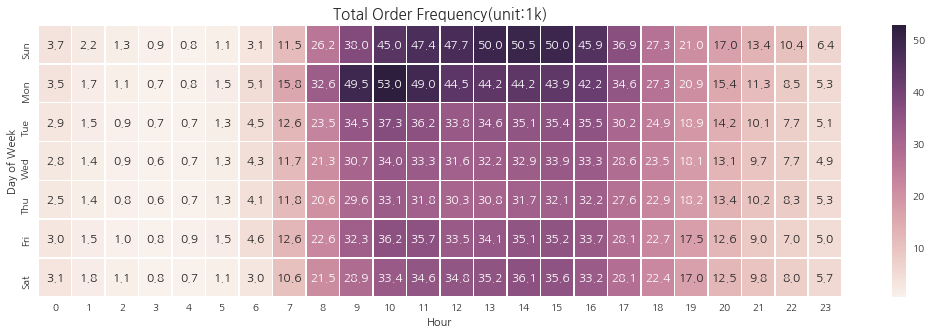

In [7]:
drawWeekHour(order_ds, values='order_id', title="Total Order Frequency(unit:1k)", aggfunc=lambda x: len(x)/1000)

### Q1. 주문하는 고객이 많은 것일까? 고객당 주문 건수가 많은 것인가? 
* Let's look at unique users heatmap
* similar to orders heatmap!!

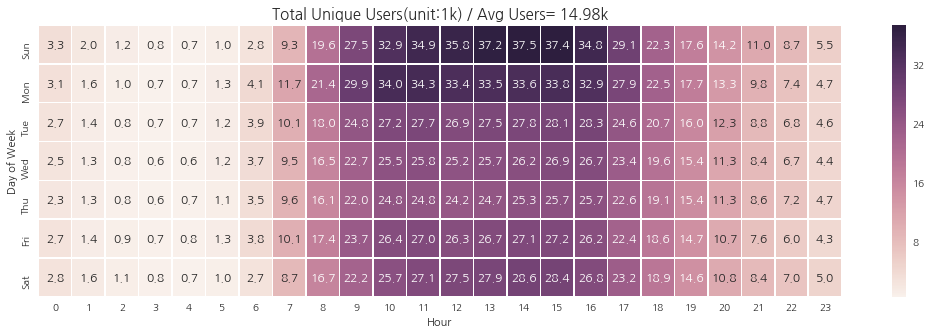

In [8]:
avg_users = round(order_ds.groupby(['order_dow','order_hour_of_day']).agg({'user_id':lambda x: len(x.unique())/1000}).mean().values[0],2)
drawWeekHour(order_ds, values='user_id', title="Total Unique Users(unit:1k) / Avg Users= {}k".format(avg_users), aggfunc=lambda x: len(x.unique())/1000)

* 그럼 이제 고객당 주문 건수를 보자?
 * 특이하게 월요일 오전(8-10h)의 오더가 많음 정기적인 오더가 많나? (해석이 맞나?)

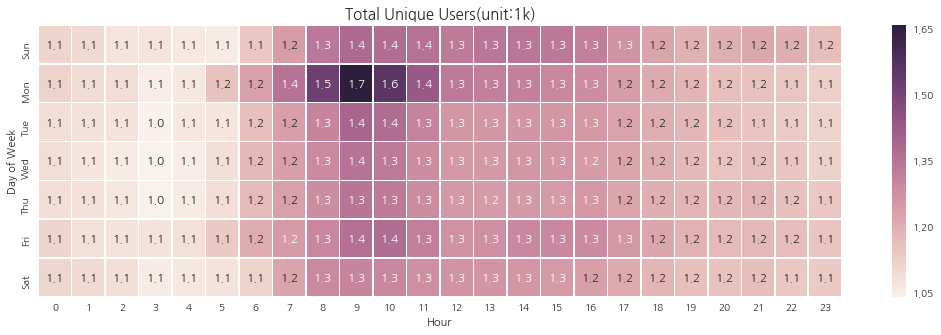

In [9]:
drawWeekHour(order_ds, values='user_id', title="Total Unique Users(unit:1k)"
             , aggfunc=lambda x: len(x)/len(x.unique()))

### <span style="color:red">A1) 주문하는 고객이 많아서임 </span>

#### 그럼 월요일 오전 9시에는 어떤 물건을 살까? 혹시 특이하게 많이 사는것이 있을까?
* 뭔가 특이한것을 살것 같은 촉!! 이 온다. 

In [10]:
merge_order_product_ds = order_product_ds.merge(order_ds, on='order_id' )
merge_order_product_ds = merge_order_product_ds.merge(product_ds, on='product_id')

In [11]:
hour_9_order_product_ds = merge_order_product_ds[merge_order_product_ds.order_hour_of_day==9]
grouped = hour_9_order_product_ds[:].groupby(['order_dow'])

In [12]:
topn = 5
hour_9_popluar_product = []
for (dow,rows) in grouped:
    sub_ds = rows.groupby('product_id', as_index=False).agg({'order_id':len}).sort_values('order_id', ascending=False)[:topn]
    sub_ds['dow'] = dow
    sub_ds['rank'] = list(range(0,topn))
    hour_9_popluar_product.append(sub_ds)

# pd.options.display.max_rows=200
hour_9_popluar_product_ds = pd.concat(hour_9_popluar_product).sort_values(['rank','dow']).merge(product_ds, on='product_id')\
.pivot(index='dow',columns='rank',values='product_name')
hour_9_popluar_product_ds.index = index2day

* 그냥 뻘생각 이었다. 
* 그냥 사람들은 월요일 아침에 다른 날보다 바나나와 우유을 더 많이 먹나 보다 

In [13]:
hour_9_popluar_product_ds

rank,0,1,2,3,4
Sun,Banana,Bag of Organic Bananas,Organic Baby Spinach,Organic Strawberries,Organic Hass Avocado
Mon,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Tue,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Wed,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Thu,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Fri,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Sat,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado


### 이와 뽑음 김에 가장 잘 팔리는 상품 이 뭔지도 보자
### Bestseller  20 product

In [14]:
def topItemEachGroup(ds, group_name, sort_name, topn):
    concat_list = []
    for (key, rows) in ds.groupby(group_name):
        sub_ds = rows.sort_values(sort_name, ascending=False)[:topn]
        sub_ds['rank'] = list(range(1,topn+1))
        concat_list.append(sub_ds)

    return pd.concat(concat_list)

In [15]:
def drawRankTrend(pivot_ds, ylabel='Rank'):
    sns.set(style="whitegrid", palette="colorblind", font_scale=1.3, rc={'font.family':'NanumGothic'} )

    index_max = pivot_ds.index.max()
    rank_max = pivot_ds.max().max()
    pivot_ds = pivot_ds.applymap(lambda x:rank_max-x+1)
    pivot_ds.plot(marker='o', figsize=(16,12), cmap='Dark2', xticks=pivot_ds.index, legend=None )
    
    plt.yticks(np.arange(rank_max,0,-1), np.arange(1,rank_max+1))
    for name, rank in pivot_ds.loc[index_max].sort_values(ascending=False).dropna().iteritems():
        plt.text(index_max*1.01,rank,name)
    plt.ylabel(ylabel)
    plt.show()
    

### Bestseller  20 product Hour Of Day Trend

In [16]:
hour_product_ds = merge_order_product_ds.groupby(['product_name','order_hour_of_day'], as_index=False).agg({'order_id':len})
hour_top_product_ds = topItemEachGroup(hour_product_ds, 'order_hour_of_day', 'order_id' , 20)
hour_top_product_pivot_ds = hour_top_product_ds.pivot(index='order_hour_of_day', columns='product_name', values='rank') 

* 1~6 위까지는 거의 변함이 없고, 그 이후 변화가 좀 있는듯하다. 
* Working Hour(9H~17H)와 그외 시간 패턴이 많이 다른것을 볼수 있다. 

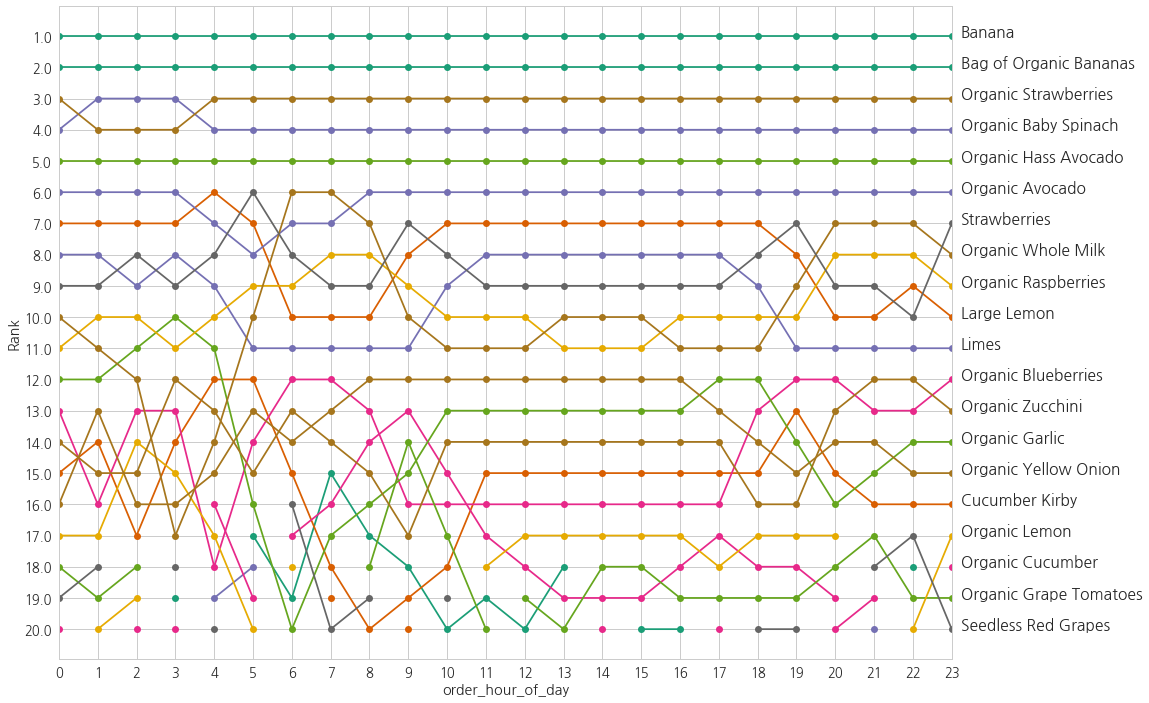

In [17]:
drawRankTrend(hour_top_product_pivot_ds)

### Bestseller  20 product Day Of Week Trend

In [18]:
rank_ds = merge_order_product_ds.groupby(['product_name','order_dow'], as_index=False).agg({'order_id':len})
rank_ds = topItemEachGroup(rank_ds, 'order_dow', 'order_id' , 20)
rank_pivot_ds = rank_ds.pivot(index='order_dow', columns='product_name', values='rank') 

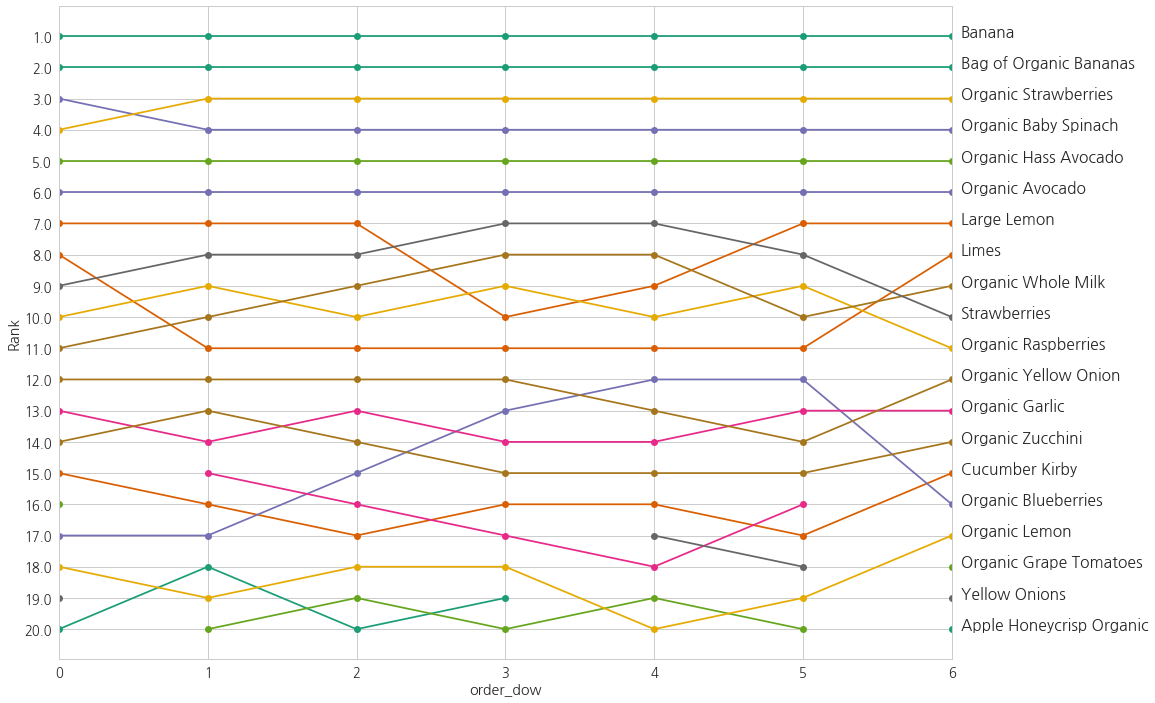

In [19]:
drawRankTrend(rank_pivot_ds)

### Q2 한번의 주문(cart)에 상품을 많이 닮아 구매하는  요일/시간은?
* weekday-hour : Product cnt per a order
* 주말(토/일) Order 그리고 밤(21~23) 늦은 주문 시 한번에 상품 주문 개수가 많음 
 * 시간적 여유가 많을때 사품 주문량이 많은듯합
 * 쇼핑 여유가 있을때와 없을 때와의 다른 상품 패턴이 있을까?

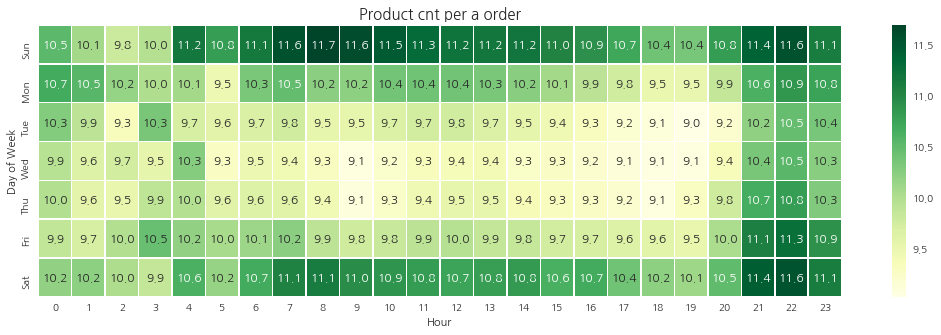

In [20]:
drawWeekHour(order_ds, values='product_cnt', title="Product cnt per a order", aggfunc=lambda x: np.mean(x), cmap='YlGn')

### 얼마나 자주 주문하는가? (다시 주문하기 까지 걸리는 평균 일수 )
 * 수치가 작을 수록 주문과 주문까지의 경과되는 텀 일수가 작음(그래서 자주 주문한다고 볼수 있음)
* 주말과 새벽이 재 주문까지 걸리는 시간이 김
* 새벽의 주문 텀이 긴 이유는 새벽에 깨어 있을 확률이 적어서 주문할 확률이 적은것이 아닌가? 하는 생각이 듦
  -> 

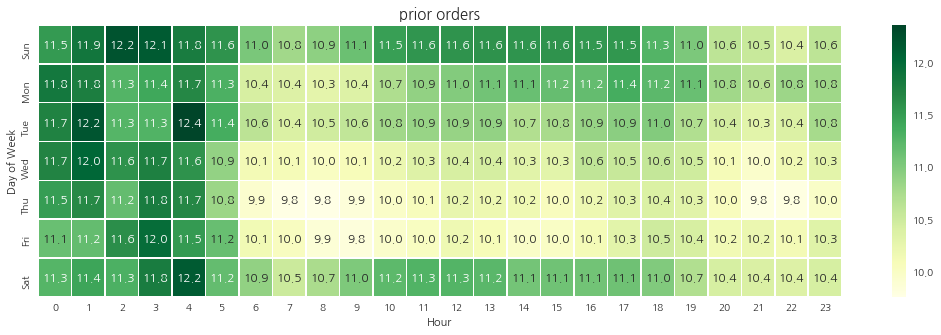

In [21]:
drawWeekHour(order_ds, values='days_since_prior_order', title="prior orders", aggfunc=lambda x: np.mean(x), cmap='YlGn')

In [22]:
sns.set(style="whitegrid", palette="colorblind", font_scale=1.4, rc={'font.family':'NanumGothic'} )

---
## Reorder Analysis
###  Q3. 주문 횟수가 많아 질수록 재주문까지 걸리는 기간이 짧아 질까? Yes!!!
* 유저별 주문 순번과 재 주문 경과된 시간 관계는(days_since_prior_order)?
 * <span style="color:red"> Yes!!! 
 * <span style="color:red"> 주문횟수가 많다는것은 충성고객일듯하고 그래서 재주문 경과 일수가 짧은것으로 추측됨 </span> 
* 유저별 주문을 많을 할수록 주문당 상품 구매수가 많을까? <span style="color:red"> 그건 상관이 없음 !!! </span>


In [23]:
print("Avg days_since_prior_order {} Days".format( round(order_ds.days_since_prior_order.mean(),2)))

Avg days_since_prior_order 10.71 Days


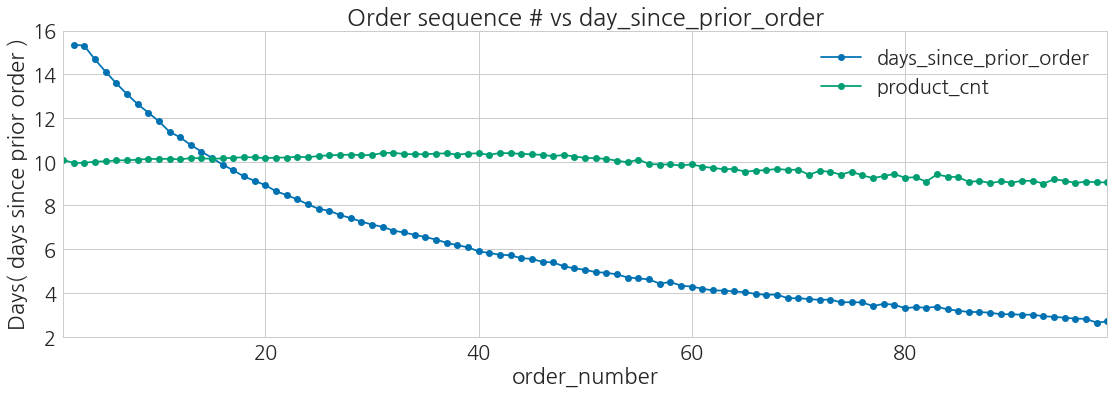

In [24]:
sns.set(style="whitegrid", palette="colorblind", font_scale=2, rc={'font.family':'NanumGothic'} )

order_ds.groupby('order_number').agg({'days_since_prior_order':np.mean, 'product_cnt':np.mean})\
    .plot(figsize=(16,6), title="Order sequence # vs day_since_prior_order", marker='o' )
plt.ylabel('Days( days since prior order )')
plt.tight_layout()
plt.show()

### Q4. 재주문 기간이 짧을 수록 이전에 주문에서 구매했던 Product이 많을까?

In [25]:
merge_order_product_ds = order_product_ds.merge(order_ds, on='order_id' )

In [26]:
reordered_since_days_ds = merge_order_product_ds.groupby(['days_since_prior_order','reordered']).agg({'product_id':len})
reordered_since_days_ds = reordered_since_days_ds.reset_index().pivot(index='days_since_prior_order', columns='reordered', values='product_id')
reordered_since_days_ds['reorder_rate'] = reordered_since_days_ds[1] /reordered_since_days_ds.sum(axis=1)
avg_reordered_rate = round(reordered_since_days_ds[1].sum() / reordered_since_days_ds[[0,1]].sum().sum(),2)

### <span style=color:red> A4) 다시 주문하는 기간이 짧을 수록 재구매(reorder) 상품 비율이 높다.</span>
* 많이 높지는 않다 평균 대비 5% 정도?? 
* 상품 예측에 feature로 할 정도의 특징점이 될까?? 

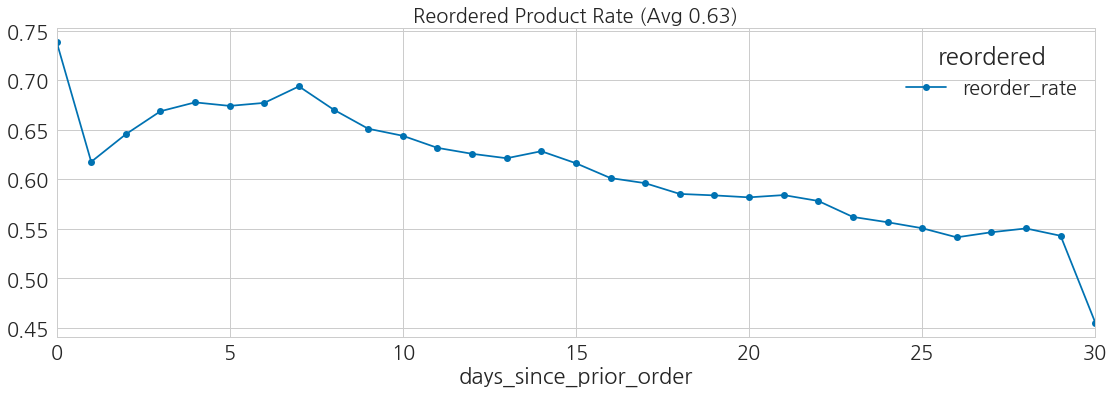

In [27]:
reordered_since_days_ds[['reorder_rate']].plot(kind='line', marker='o',figsize=(16,6))
plt.title("Reordered Product Rate (Avg {})".format(avg_reordered_rate), fontsize=20)
plt.tight_layout()
plt.show()

### Q5. 주문 순번이 큰 즉 많이 주문을 한 오더에는 재구매 상품이 많을까? 


In [28]:
reordered_order_num_ds = merge_order_product_ds.groupby(['order_number','reordered']).agg({'product_id':len})
reordered_order_num_ds = reordered_order_num_ds.reset_index().pivot(index='order_number', columns='reordered', values='product_id')
reordered_order_num_ds['reorder_rate'] = reordered_order_num_ds[1] /reordered_order_num_ds.sum(axis=1)
avg_reordered_rate = round(reordered_order_num_ds[1].sum() / reordered_order_num_ds[[0,1]].sum().sum(),2)
reordered_order_num_ds.fillna(0, inplace=True)

### <span style=color:red> A5) 주문 순번이 큰 즉 많이 주문했을 경우는 기존의 상품을 살 확률이 높네요. .</span>
* 40번 이상 주문한 사람의 주문순번엔는 재구매 상품이 80%이상 이네요. 
* 재구매한 상품이 많기 때문에 주문이 많았다고 보는것도 당연한 이치 일듯합니다. 
* 생각해 보면 당연하기 때문에 예측 feature로 쓰기에도 당연히 적용되야 할듯하네요. 

### It looks like log curve!!!! 
* When order number is 40 more, Reorder-Rate exceed 80% more!!! 

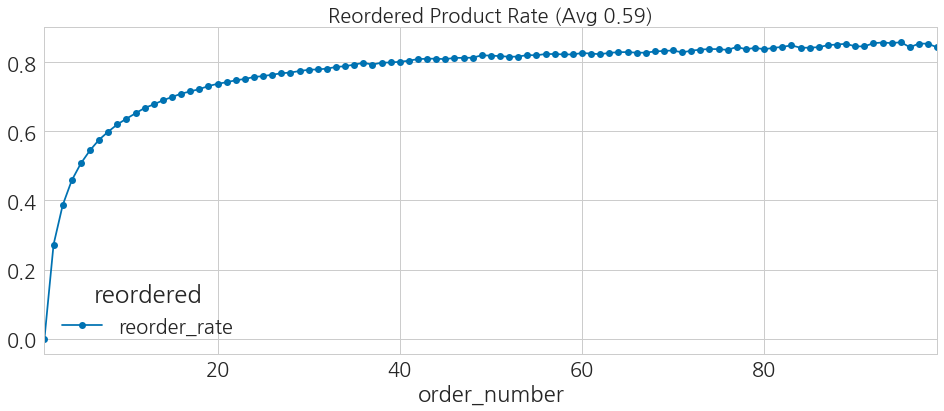

In [29]:
reordered_order_num_ds[['reorder_rate']].plot(kind='line', marker='o',figsize=(16,6))
plt.title("Reordered Product Rate (Avg {})".format(avg_reordered_rate), fontsize=20)
plt.show()

### Q6) 어떤 상품이 Reorder 비율이 높을까?
* 1000개 이상 주문한 상품에서 재구매 비율이 높은 20개 상품은?

In [30]:
product_reorder_ds = merge_order_product_ds.groupby(['product_id']).agg({'order_id':len,
                                                                         'reordered':lambda x: len(x[x>0]),
                                                                         'user_id':lambda x: len(x.unique())})

In [31]:
convert_colnames = {'user_id':'unique_users','reordered':'reorder' , 'order_id':'total_order'}
product_reorder_ds.columns = [  convert_colnames[col] for col in product_reorder_ds.columns]

In [32]:
product_reorder_ds['reorder_rate'] = round(product_reorder_ds.reorder / product_reorder_ds.total_order,2)
product_reorder_ds['orders_per_user'] = round(product_reorder_ds.total_order/product_reorder_ds.unique_users,2)
product_reorder_ds = product_reorder_ds.merge(product_ds, left_index=True, right_on='product_id')

### <span style=color:red> A6)  84구역의 우유 제품이 대부분을 차지함 83%의 높은 재구매 비율임</span>
* 우유이외는 바나나, 물 제품이 있음
* 당연히 유저당 주문수도 비례하여 높음

In [33]:
product_reorder_ds[product_reorder_ds.total_order>1000].sort_values('reorder_rate', ascending=False)\
        [['product_name','total_order', 'reorder_rate', 'aisle_id','orders_per_user']][:20]

,product_name,total_order,reorder_rate,aisle_id,orders_per_user
45503,Whole Organic Omega 3 Milk,9108,0.86,84,7.15
9291,Half And Half Ultra Pasteurized,2921,0.86,84,7.23
47230,Ultra-Purified Water,1489,0.86,115,7.02
5513,Organic Homogenized Whole Milk,3970,0.86,84,7.03
43393,Organic Lactose Free Whole Milk,8477,0.86,91,7.09
34196,Goat Milk,5185,0.85,84,6.66
29446,"Milk, Organic, Vitamin D",20198,0.85,84,6.87
38688,Organic Reduced Fat Milk,35663,0.85,84,6.70
31719,Organic Whole Milk,9842,0.84,84,6.30
24520,Lowfat Goat Milk,1159,0.84,84,6.20


* 추가로, 구역(aisle)별 재구매 상품 비율 상위 20, 하위 20 은?

In [34]:
# product_reorder_ds.groupby('aisle_id').agg({'product_name':                                           lambda x: })
from collections import defaultdict
import operator

def popularWords(names, topn=2):
    wordFrequency = defaultdict(int)
    def updateWords(words):
        for word in words :
            if len(word)>1:
                wordFrequency[word] += 1
    names.apply(lambda x: updateWords(x.split()))
    tops = sorted(wordFrequency.items(), key=operator.itemgetter(1),reverse=True)[:topn]
    return " ".join([n[0] for n in tops])

In [35]:
aisle_ds = product_ds.groupby('aisle_id').agg({'product_name':popularWords
                                               , 'product_id':lambda x:len(x.unique())})
# aisle_ds.columns = ['products','product_names']

In [36]:
aisle_order_stat_ds = product_reorder_ds.groupby('aisle_id').agg({'total_order':sum, 'reorder':sum})
aisle_order_stat_ds['reorder_rate'] = round(aisle_order_stat_ds.reorder / aisle_order_stat_ds.total_order, 2)
aisle_order_stat_ds = aisle_order_stat_ds.merge(aisle_ds, left_index=True, right_index=True).sort_values('reorder_rate', ascending=False)
aisle_order_stat_ds.index = aisle_order_stat_ds.product_name + "(" + aisle_order_stat_ds.index.astype(str)+")"

* 재구매 비율이 높은 구역(aisle)은 유통기간이 짧은 우유, 물, 커피, 주스 등 신선 농산물 위주
* 재구매 비율이 낮은 구역(aisle)은 유통기간이 긴 제품 위주로 보인다. 
* 이처럼 재구매 비율의 분석의 유통기간(또는 소비기간)에 대비하여 높은지 낮인지에 따라 구매 성향을 더 알수 있을듯 하다.

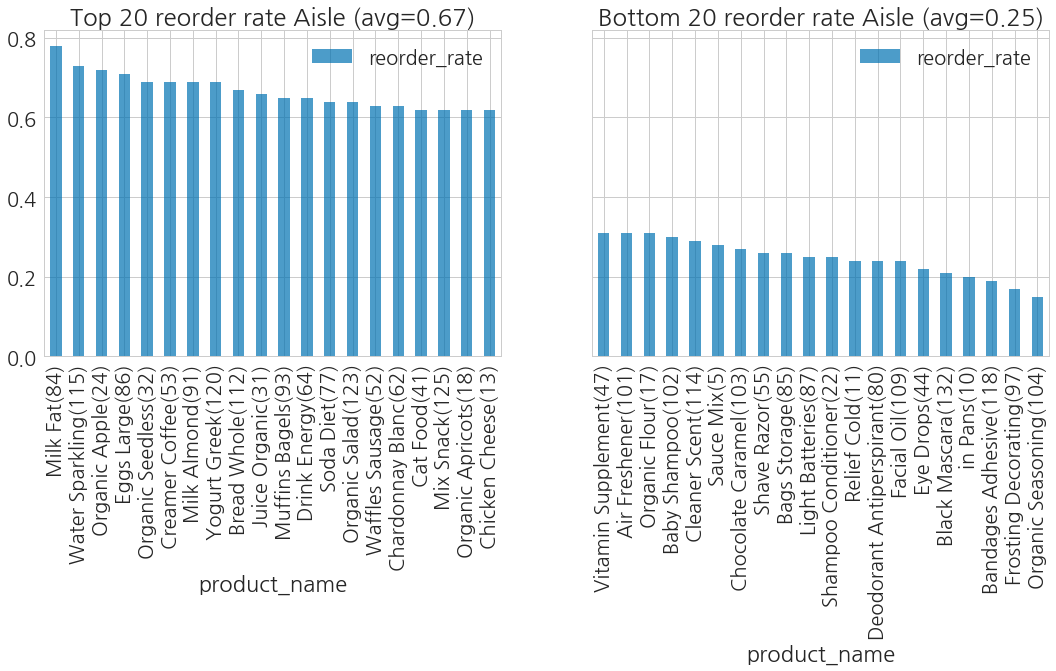

In [37]:
sns.set(style="whitegrid", palette="colorblind", font_scale=2, rc={'font.family':'NanumGothic'} )

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

top20_ds = aisle_order_stat_ds[['reorder_rate']][:20]
top20_ds.plot(kind='bar', figsize=(16,6), alpha=.7, ax=ax1
             , title='Top 20 reorder rate Aisle (avg={})'.format(toReadable(top20_ds.reorder_rate.mean())))

bottom20_ds = aisle_order_stat_ds[['reorder_rate']][-20:]
bottom20_ds.plot(kind='bar', figsize=(18,6), alpha=.7, ax=ax2
                , title='Bottom 20 reorder rate Aisle (avg={})'.format(toReadable(bottom20_ds.reorder_rate.mean())))
plt.show()

### Q7) 주문이 많은 상품은 재구매율이 높다? 
* 당연히 그럴것이다. 데이터로도 확인해 보자 
* (참고)reorder_rate(0 ~ 1.), total_order(1~500000)의 데이터 단위가 너무 차이나 나기 때문에 상관 계수를 spearman 으로 측정함 

### <span style=color:red> A7) 예상대로 주문수와 재구매비율은 양의 상관관계(0.59)가 높게 나왔다. </span>
* 이 데이터를 보면서 구매수는 많은데 재구매비율이 낮은 상품은? 발전가능성이 높은 상품인가? 의문의 들기도 했다. 

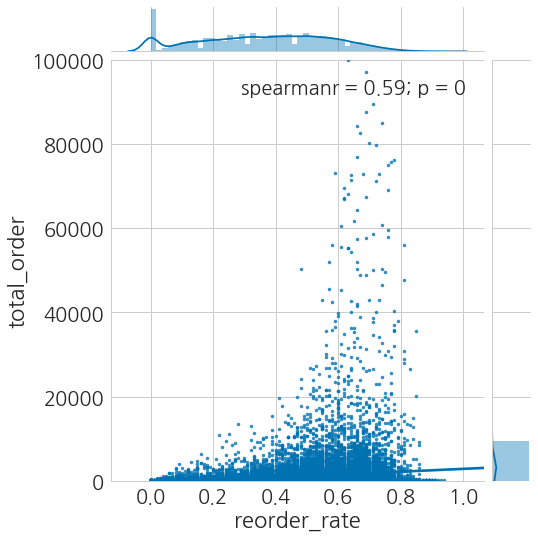

In [38]:
from scipy.stats import spearmanr
g = sns.jointplot("reorder_rate", "total_order", kind="reg", marker='.', ylim=(0,100000), size=8, ratio=8
                  , stat_func=spearmanr
                  , data=product_reorder_ds)

---
## 사용자의 Order 정보로 유사한 상품끼로 묶어보기
* word2vec으로 product2vec을 만든다. 
 * word = product_id
 * order = scentence = [product_id1, product_id2, ... ]
* 학습된 product vector로 클러스터링
* 200번이상 주문된 상품만 학습에 포함됨

In [39]:
order_product_list = merge_order_product_ds\
    .sort_values(['user_id','order_id','add_to_cart_order'])[['order_id','product_id']]\
    .values.tolist()

product_corpus = []
sentence = []
new_order_id = order_product_list[0][0]
for (order_id, product_id) in order_product_list:
    if new_order_id != order_id:
        product_corpus.append(sentence)
        sentence = []
        new_order_id = order_id
    sentence.append(str(product_id))

In [40]:
from gensim.models import Word2Vec

# model = Word2Vec(product_corpus, window=6, size=100, workers=4, min_count=200)
# model.save('./resource/prod2vec.100d.model')
model = Word2Vec.load('./resource/prod2vec.100d.model')

In [41]:
def toProductName(id):
    return product_ds[product_ds.product_id==id]['product_name'].values.tolist()[0]
toProductName(24852)

'Banana'

In [42]:
def most_similar_readable(model, product_id):
    similar_list = [(product_id,1.0)]+model.wv.most_similar(str(product_id))
    
    return [( toProductName(int(id)), similarity ) for (id,similarity) in similar_list]

### What is the most similar?
* most similar to banana(24852) is ..

In [43]:
pd.DataFrame(most_similar_readable(model, 24852), columns=['product','similarity'])

,product,similarity
0,Banana,1.000000
1,Bag of Organic Bananas,0.691602
2,Seedless Red Grapes,0.586912
3,Bartlett Pears,0.579184
4,XL Emerald White Seedless Grapes,0.529524
5,Granny Smith Apples,0.524805
6,Total 0% Greek Yogurt,0.522481
7,Organic Banana,0.522008
8,Organic Fuji Apple,0.507403
9,Total 2% All Natural Plain Greek Yogurt,0.474835


* most similar to Drinking Water(27845) is ..

In [44]:
pd.DataFrame(most_similar_readable(model, 27845), columns=['product','similarity'])

,product,similarity
0,Organic Whole Milk,1.000000
1,Organic Reduced Fat Milk,0.775674
2,Organic Lowfat 1% Milk,0.714389
3,Whole Organic Omega 3 Milk,0.680077
4,Organic Whole Grassmilk Milk,0.637049
5,Organic Multigrain Waffles,0.628958
6,Organic Lactose Free Whole Milk,0.621932
7,Organic Reduced Fat Omega-3 Milk,0.614397
8,Organic Mini Homestyle Waffles,0.611356
9,1% Lowfat Milk,0.609977


* most similar to Organic Whole Milk(40939) is .. 

In [45]:
pd.DataFrame(most_similar_readable(model, 40939), columns=['product','similarity'])

,product,similarity
0,Drinking Water,1.000000
1,Boneless & Skinless Chicken Breasts,0.763584
2,Nacho Cheese Flavored Tortilla Chips,0.761863
3,Foam Bowls,0.747945
4,Tea,0.734563
5,Margarine,0.733385
6,Diet,0.729550
7,Organic 2% Milk,0.723830
8,Salted Sweet Cream Butter Quarters,0.721233
9,Disinfectant Spray,0.704162


In [46]:
pd.DataFrame(most_similar_readable(model, 48697), columns=['product','similarity'])

,product,similarity
0,Canola Oil,1.000000
1,Light Brown Sugar,0.746442
2,Unsalted Butter,0.727266
3,Corn Starch,0.721181
4,Panko Bread Crumbs,0.720982
5,Refined Canola Oil,0.703475
6,Unbleached All-Purpose Flour,0.696961
7,Unbleached Bread Flour,0.695501
8,Whole Wheat Flour,0.694387
9,Active Dry Yeast,0.693718


### Product2Vec 잘 학습된듯 하다.

* Kmean로 학습된 Product Vector로 500 clusters 생성
* using kmeans ( k=500 )

In [47]:
import kmeans

In [48]:
def clustering(model, k=500, delta=0.00000001, maxiter=200):
    movie_vec = model.wv.syn0
    centres, index2cid, dist = kmeans.kmeanssample(movie_vec, k, 
                                                   metric = 'cosine', 
                                                   delta = delta, 
                                                   nsample = 0, maxiter = maxiter,)
    clustered_ds = pd.DataFrame( [ (a, b, c) for a, b, c in zip(model.wv.index2word, index2cid, dist )],
                 columns=['product_id', 'cid', 'dist'] ).sort_values(['cid','dist'], ascending=True)

    prod2cid = { product_id:cid for product_id,cid in zip(model.wv.index2word, index2cid) }

    return (centres, index2cid, dist, clustered_ds, prod2cid)

In [49]:
(centres, index2cid, dist, clustered_ds, prod2cid) = clustering(model)

kmeans: X (5000, 100)  centres (500, 100)  delta=1e-08  maxiter=200  metric=cosine
kmeans: 15 iterations  cluster sizes: [ 8 13  8 10  8 12 27 28 14 17  5 15 11  7  7  5 16  8  4  8  7  7  4 13  3
  4 13  5  5 10  6  7  5 19 14 18  7 12 10  8  3 12 22  7  9 11  6  9 13 11
 15  2 21  6  7 13 12 23  3  2  6 19  5  2  3 30 20 15  9  4 13 17  5 10  3
 12 14  7  5 23  9  6  5  6 27 10  7  8 13  5  6 24 14  6  9 24 19 11 12  8
 20 13  4  9  7 11  2 24 14 18 11 17 17 16  5  4 19 14 10  6  9  1  6 16 12
  4 11  4  6 20 17  7  3  4  5 18 12 23  2 10 32 11  8  6  8  6  5  8 23 14
 21 17  8  2  1  5  8  3 11 10 16  3 10 36 35 20  8 15  5  8  8 11  4  2  9
 11 11  6 15  8 16 11 19  6  7  2  7  3  6  7  6  3  8 16  6 10 13 10 12  4
  8  4 12  1  9  4  3 10  4 11  7  2  5 10 10 12 10  5  1  6  9  9 18  6  3
  5  5  1  8  6  5 14 11 13  4 12 10  5  6  7 10  8 11  1 15 10  8 13  3  1
  2  4  9  5 12 12  4  6  3 17 13  9 24 11 10  3  6 28 10 12  6  1  5 16  8
  1  3  8 17  8 12  6  2 24  6  9  9  2  7 

In [50]:
clustered_ds.product_id = clustered_ds.product_id.apply(pd.to_numeric)

In [51]:
def idToProductDesc(id):
    return product_ds[product_ds.product_id==id][['product_name','aisle_id']].values.tolist()[0]
    
def getProductNames(product_id_list):
    return [ idToProductDesc(int(product_id)) for  product_id in product_id_list ]

import urllib
def printClusterMembers(cluster_id, topn=10):
    members = getProductNames(clustered_ds[clustered_ds.cid==cluster_id].product_id[:topn].tolist())
    for member in members:
        print("{aisle} / {name}  https://www.google.co.kr/search?tbm=isch&q={q}".format( 
            aisle=member[1], name=member[0], q=urllib.parse.quote_plus(member[0]) ) 
        )

### 클러스터링 결과보기
### <span style="color:red">샘플로 5개의 부류를 보니 유사한것끼리 아주 잘 묶였다.</span>

* Cluster ID = 0 th

In [52]:
printClusterMembers(1, topn=10)

1 / Mediterranean Orzo Salad  https://www.google.co.kr/search?tbm=isch&q=Mediterranean+Orzo+Salad
1 / Lentil Salad  https://www.google.co.kr/search?tbm=isch&q=Lentil+Salad
1 / Tuscan Kale & Quinoa Salad  https://www.google.co.kr/search?tbm=isch&q=Tuscan+Kale+%26+Quinoa+Salad
1 / Mini Falafel With Tahini Sauce  https://www.google.co.kr/search?tbm=isch&q=Mini+Falafel+With+Tahini+Sauce
1 / BBQ Chopped Salad  https://www.google.co.kr/search?tbm=isch&q=BBQ+Chopped+Salad
30 / Burrito Grand  https://www.google.co.kr/search?tbm=isch&q=Burrito+Grand
1 / Santa Fe Fiesta Salad  https://www.google.co.kr/search?tbm=isch&q=Santa+Fe+Fiesta+Salad
13 / Enchilada Wrap  https://www.google.co.kr/search?tbm=isch&q=Enchilada+Wrap
13 / Breakfast Burrito With Potatoes Jack & Cheddar Cheese & Meatless Chorizo  https://www.google.co.kr/search?tbm=isch&q=Breakfast+Burrito+With+Potatoes+Jack+%26+Cheddar+Cheese+%26+Meatless+Chorizo
1 / Garden Minestrone Soup  https://www.google.co.kr/search?tbm=isch&q=Garden+Mines

* Cluster ID = 100 th

In [53]:
printClusterMembers(100, topn=10)

21 / Cheddar Cheese Alternative  https://www.google.co.kr/search?tbm=isch&q=Cheddar+Cheese+Alternative
86 / Vegan Egg  https://www.google.co.kr/search?tbm=isch&q=Vegan+Egg
42 / Alfredo Cheezy Mac  https://www.google.co.kr/search?tbm=isch&q=Alfredo+Cheezy+Mac
21 / Dairy-Free Cheddar Style Wedges  https://www.google.co.kr/search?tbm=isch&q=Dairy-Free+Cheddar+Style+Wedges
21 / Irresistible Dairy Free Slices Provolone Style Cheese Alternative  https://www.google.co.kr/search?tbm=isch&q=Irresistible+Dairy+Free+Slices+Provolone+Style+Cheese+Alternative
21 / Vegan Chao Creamy Original Cheese Slices  https://www.google.co.kr/search?tbm=isch&q=Vegan+Chao+Creamy+Original+Cheese+Slices
42 / Dairy Free Gluten Free Mushroom & Roasted Garlic Pizza  https://www.google.co.kr/search?tbm=isch&q=Dairy+Free+Gluten+Free+Mushroom+%26+Roasted+Garlic+Pizza
21 / Cheese Alternative, American Style, Slices  https://www.google.co.kr/search?tbm=isch&q=Cheese+Alternative%2C+American+Style%2C+Slices
21 / Chao, Vegan

* Cluster ID = 200 th

In [54]:
printClusterMembers(200, topn=10)

69 / Ramen, Vegan, Miso  https://www.google.co.kr/search?tbm=isch&q=Ramen%2C+Vegan%2C+Miso
69 / Vegan Hot & Sour Noodle Soup  https://www.google.co.kr/search?tbm=isch&q=Vegan+Hot+%26+Sour+Noodle+Soup
69 / Vegan Big Cup Pad Thai Noodle Soup  https://www.google.co.kr/search?tbm=isch&q=Vegan+Big+Cup+Pad+Thai+Noodle+Soup
76 / Bombay Potatoes Vegetarian  https://www.google.co.kr/search?tbm=isch&q=Bombay+Potatoes+Vegetarian
76 / Indian Cuisine Bengal Lentils  https://www.google.co.kr/search?tbm=isch&q=Indian+Cuisine+Bengal+Lentils
69 / Vegan Black Bean & Lime Soup  https://www.google.co.kr/search?tbm=isch&q=Vegan+Black+Bean+%26+Lime+Soup
69 / Sesame Chicken Flavor Asian Soup  https://www.google.co.kr/search?tbm=isch&q=Sesame+Chicken+Flavor+Asian+Soup
76 / Spinach Dal Indian Cuisine  https://www.google.co.kr/search?tbm=isch&q=Spinach+Dal+Indian+Cuisine
76 / Channa Masala Indian Cuisine  https://www.google.co.kr/search?tbm=isch&q=Channa+Masala+Indian+Cuisine
66 / Asian Vegetable Ramen  https:/

* Cluster ID = 300 th

In [55]:
printClusterMembers(300, topn=10)

45 / Red Licorice  https://www.google.co.kr/search?tbm=isch&q=Red+Licorice
45 / Peppermint Patties  https://www.google.co.kr/search?tbm=isch&q=Peppermint+Patties
46 / Spearmint Gum  https://www.google.co.kr/search?tbm=isch&q=Spearmint+Gum
45 / Dark Chocolate Pomegranate  https://www.google.co.kr/search?tbm=isch&q=Dark+Chocolate+Pomegranate
45 / Dark Chocolate Chunk Chewy Granola Bars  https://www.google.co.kr/search?tbm=isch&q=Dark+Chocolate+Chunk+Chewy+Granola+Bars
78 / Variety Pack of Crackers  https://www.google.co.kr/search?tbm=isch&q=Variety+Pack+of+Crackers
45 / 49 Flavors Jelly Belly Jelly Beans  https://www.google.co.kr/search?tbm=isch&q=49+Flavors+Jelly+Belly+Jelly+Beans
117 / Fruit & Nut Medley  https://www.google.co.kr/search?tbm=isch&q=Fruit+%26+Nut+Medley
45 / Full-Size Chocolate Bars  https://www.google.co.kr/search?tbm=isch&q=Full-Size+Chocolate+Bars
3 / Sweet & Salty Nut Granola Bars Peanut  https://www.google.co.kr/search?tbm=isch&q=Sweet+%26+Salty+Nut+Granola+Bars+Pea

* Cluster ID = 400 th

In [56]:
printClusterMembers(400, topn=10)

21 / Organic Stringles Mozzarella String Cheese  https://www.google.co.kr/search?tbm=isch&q=Organic+Stringles+Mozzarella+String+Cheese
21 / Organic Mexican Blend Finely Shredded Cheese  https://www.google.co.kr/search?tbm=isch&q=Organic+Mexican+Blend+Finely+Shredded+Cheese
21 / Organic Finely Shredded Cheddar Cheese  https://www.google.co.kr/search?tbm=isch&q=Organic+Finely+Shredded+Cheddar+Cheese
21 / Organic Sticks Low Moisture Part Skim Mozzarella String Cheese  https://www.google.co.kr/search?tbm=isch&q=Organic+Sticks+Low+Moisture+Part+Skim+Mozzarella+String+Cheese
21 / Stringles Organic Colby Jack Cheese  https://www.google.co.kr/search?tbm=isch&q=Stringles+Organic+Colby+Jack+Cheese
21 / Organic Fancy Shredded Mozzarella Cheese  https://www.google.co.kr/search?tbm=isch&q=Organic+Fancy+Shredded+Mozzarella+Cheese
21 / Mexican Finely Shredded Cheese  https://www.google.co.kr/search?tbm=isch&q=Mexican+Finely+Shredded+Cheese
21 / Fancy Shredded Cheese Italian Blend  https://www.google.

* Cluster ID = 499 th

In [57]:
printClusterMembers(499, topn=10)

120 / Simply 100 Crunch Blueberry Cookie Crumble Non-Fat Greek Yogurt  https://www.google.co.kr/search?tbm=isch&q=Simply+100+Crunch+Blueberry+Cookie+Crumble+Non-Fat+Greek+Yogurt
120 / Carmel Apple Crisp Twist  https://www.google.co.kr/search?tbm=isch&q=Carmel+Apple+Crisp+Twist
120 / Flip PB&J Low-Fat Greek Yogurt  https://www.google.co.kr/search?tbm=isch&q=Flip+PB%26J+Low-Fat+Greek+Yogurt
120 / Flip Pumpkin Harvest Crisp Lowfat Greek Yogurt  https://www.google.co.kr/search?tbm=isch&q=Flip+Pumpkin+Harvest+Crisp+Lowfat+Greek+Yogurt
120 / Carmel Peanut Perfectio  https://www.google.co.kr/search?tbm=isch&q=Carmel+Peanut+Perfectio
120 / Simply 100 Crunch Strawberry Chocolate Truffle Non-Fat Greek Yogurt  https://www.google.co.kr/search?tbm=isch&q=Simply+100+Crunch+Strawberry+Chocolate+Truffle+Non-Fat+Greek+Yogurt
120 / Flip Coffee Break Bliss Greek Yogurt  https://www.google.co.kr/search?tbm=isch&q=Flip+Coffee+Break+Bliss+Greek+Yogurt
120 / Greek Yogurt Flip Salted Caramel Crunch  https://w

### It looks goooood!! 

----
###  Q8) cluster별 상품의 이용 시간 트랜드는 비슷할까?

* Extract representative keywords from each cluster.
* Reprosentative keywords : 3 words and max 15 latters
* Sort by popular order hour 

In [58]:
clusterIdToKeywords = { cid: popularWords(sub_ds.product_name,3) for cid, sub_ds in clustered_ds.merge(product_ds, on='product_id').groupby('cid')}

#### Hour of Day Trend Per cluster 

In [59]:
product_hod_ds = merge_order_product_ds.pivot_table(index='product_id', columns='order_hour_of_day', values='order_id', aggfunc=len, fill_value=0)

orderByHotHour = clustered_ds.merge(product_hod_ds, left_on='product_id', right_index=True)\
    .groupby('cid').sum()[np.arange(0,24)].idxmax(axis=1).sort_values().index

In [60]:
sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )

def drawHODCluster(ncols, nrows, startClusterNumber, step):
    fig, axes = plt.subplots(ncols=ncols, nrows = nrows, figsize=(ncols*2.5,nrows*2), sharex=True, sharey=True)

    for cid, ax  in enumerate(axes.flatten()):
        cid = startClusterNumber + (cid*step)
        if cid>=500:
            break
        cid = orderByHotHour[cid]

        product_id_list = clustered_ds[clustered_ds.cid==cid].product_id.values
        tmp_ds = product_hod_ds.loc[product_id_list].T
        hot_hour = tmp_ds.sum(axis=1).argmax()
        normalized_ds =(tmp_ds/tmp_ds.max())
        title = "{cid}th {n} products \n({keyword})".format(cid=cid, n=normalized_ds.shape[1],  keyword=clusterIdToKeywords[cid][:23])
        normalized_ds.plot(linewidth=.3, legend=False, alpha=.4, ax=ax, title=title, color='r' if hot_hour<13 else 'k')
        ax.plot((hot_hour,hot_hour),(1,0), '-.', linewidth=1, color='b')
        ax.text(hot_hour,0,"{h}h(hot)".format(h=hot_hour),color='b')

    fig.tight_layout()

###  전체 500개의 클러스터중 50개만 보자 
* 가장 많이 산 주문 된 시간 순으로 정렬하였다. 
* 가장 주문한 시간 12 시간 이전, 이후로 색상을 구분하였다. 

###  결과를 보면 
1. 각 클러스터 별로 비슷한 트랜드보인다. 즉 유사한 상품별로 시간별 구매 상향이 비슷해 보인다. 
2. 시간대로 클러스터로 구분된  구매 성향을 보면 
 1. 오전 시간에는  yogurt, milk Tea, cheese,granola 등 가벼운 식품 위주의 구매 성향이 눈에 띈다. 
 2. 오후 시간에는 ice cream, chocolate, pasta, cheese, beef 등 저녁이나 고연량(?) 음식이 눈에 띈다. 

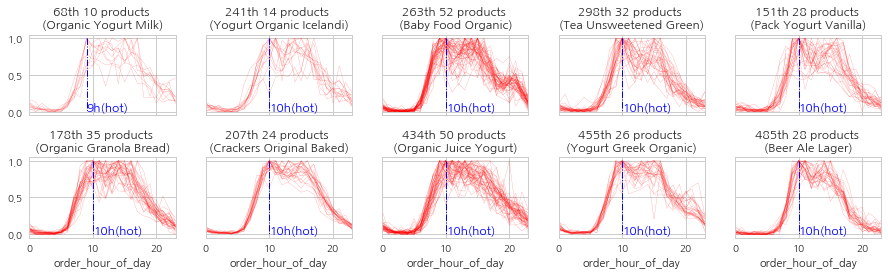

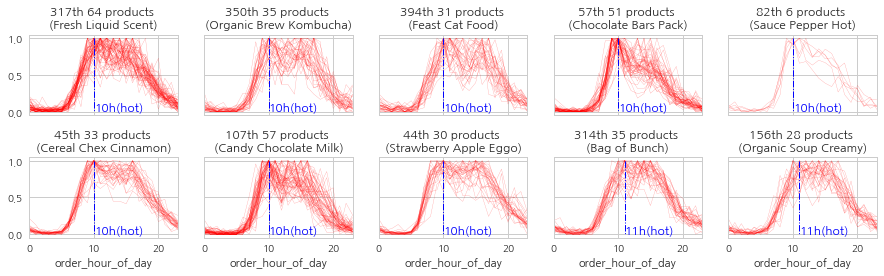

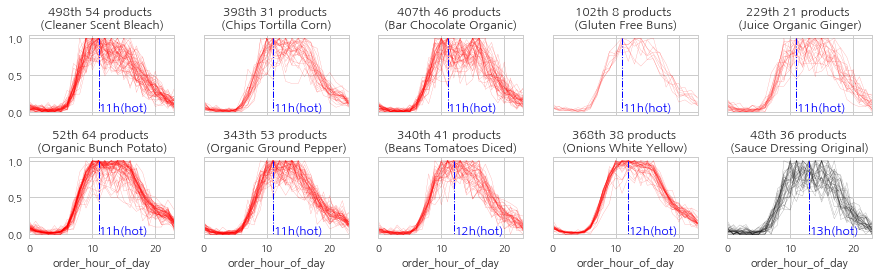

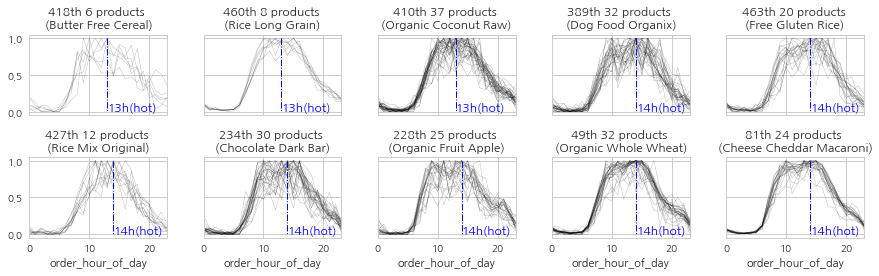

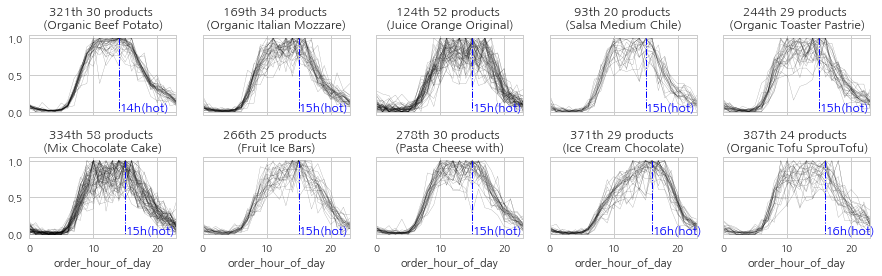

In [61]:
ncols, nrows=(5,2)
step = 10
for n in np.arange(0,500,ncols*nrows*step):
    drawHODCluster(ncols, nrows, n, step)

#### Hour of Day Trend Per cluster 

In [62]:
product_dow_ds = merge_order_product_ds.pivot_table(index='product_id', columns='order_dow', values='order_id', aggfunc=len, fill_value=0)

orderByHotDay = clustered_ds.merge(product_dow_ds, left_on='product_id', right_index=True)\
    .groupby('cid').sum()[np.arange(0,6)].idxmax(axis=1).sort_values(ascending=True).index

In [63]:
# def drawDOWCluster(ncols, nrows, startClusterNumber, step):
#     sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )
#     week_day = "Sun Mon Tue Wed Thu Fri Sat".split()
#     fig, axes = plt.subplots(ncols=ncols, nrows = nrows, figsize=(ncols*2.5,nrows*2), sharex=True, sharey=True)

#     for cid, ax  in enumerate(axes.flatten()):
#         cid = startClusterNumber + (cid*step)
#         if cid>=500:
#             break
#         cid = orderByHotDay[cid]    
#         product_id_list = clustered_ds[clustered_ds.cid==cid].product_id.values
#         tmp_ds = product_dow_ds.loc[product_id_list].T
#         hot_day = tmp_ds.sum(axis=1).argmax()
#         normalized_ds =(tmp_ds/tmp_ds.max())
#         normalized_ds.index = week_day
#         title = "{cid}th \n({keyword})".format(cid=cid, h=hot_day,  keyword=clusterIdToKeywords[cid][:23])
#         normalized_ds.plot(kind='bar', linewidth=.1, legend=False, alpha=.4, ax=ax, title=title, color='r' if hot_day in(0,6) else 'k')
#         ax.plot((hot_day,hot_day),(1,0), '-.', linewidth=2, color='b')
#         # ax.text(hot_day+.3,-.5,"{h}".format(h=week_day[hot_day]),color='b')
    
#     fig.tight_layout()

In [64]:
def drawDOWCluster(ncols, nrows, cid_list):
    sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )
    week_day = "Sun Mon Tue Wed Thu Fri Sat".split()
    fig, axes = plt.subplots(ncols=ncols, nrows = nrows, figsize=(ncols*2.5,nrows*2), sharex=True, sharey=True)

    for cid, ax  in zip(cid_list, axes.flatten()):
        product_id_list = clustered_ds[clustered_ds.cid==cid].product_id.values
        tmp_ds = product_dow_ds.loc[product_id_list].T
        hot_day = tmp_ds.sum(axis=1).argmax()
        normalized_ds =(tmp_ds/tmp_ds.max())
        normalized_ds.index = week_day
        title = "{cid}th \n({keyword})".format(cid=cid, h=hot_day,  keyword=clusterIdToKeywords[cid][:23])
        normalized_ds.plot(kind='bar', linewidth=.1, legend=False, alpha=.4, ax=ax, title=title, color='r' if hot_day in(0,6) else 'k')
        ax.plot((hot_day,hot_day),(1,0), '-.', linewidth=2, color='b')
        # ax.text(hot_day+.3,-.5,"{h}".format(h=week_day[hot_day]),color='b')
    
    fig.tight_layout()

In [65]:
dow_cid_ds = clustered_ds.merge(product_dow_ds, left_on='product_id', right_index=True)\
    .groupby('cid').sum()[np.arange(0,6)].idxmax(axis=1).sort_values(ascending=True)
dow_cid_ds.name= 'dow'
dow_cid_ds = dow_cid_ds.reset_index()

In [66]:
dow_cid_ds.groupby('dow').count()

,cid
dow,
0,357
1,135
4,2
5,6


###  전체 500개의 클러스터 중 구매가 많이 일어난 요일별 클러스트를 구분하여 어떤 패턴이 있는지 보자 
* 전체 500개의 클러스터 중 아래와 같이 샘플링하여 보자 
 * 일요일 -> 30 클러스터, 
 * 월요일 -> 20 클러스터 , 
 * 목요일->2클러스터, 
 * 금요일 -> 5클러스터
* 여기서 요일인 해당 클러스터의 상품이 가장 많이 팔린 요일 기준이다. 
####  결과는 요일별 제품의 구매 패턴의 특징점이 있다. 

#### 일요일에 가장 많이 팔린 클러스터들의 요일별 이용 구패 패턴이다. 
 * 가장많이 구매하는 요일이고 다양한 상품을 많이 구매한다. 

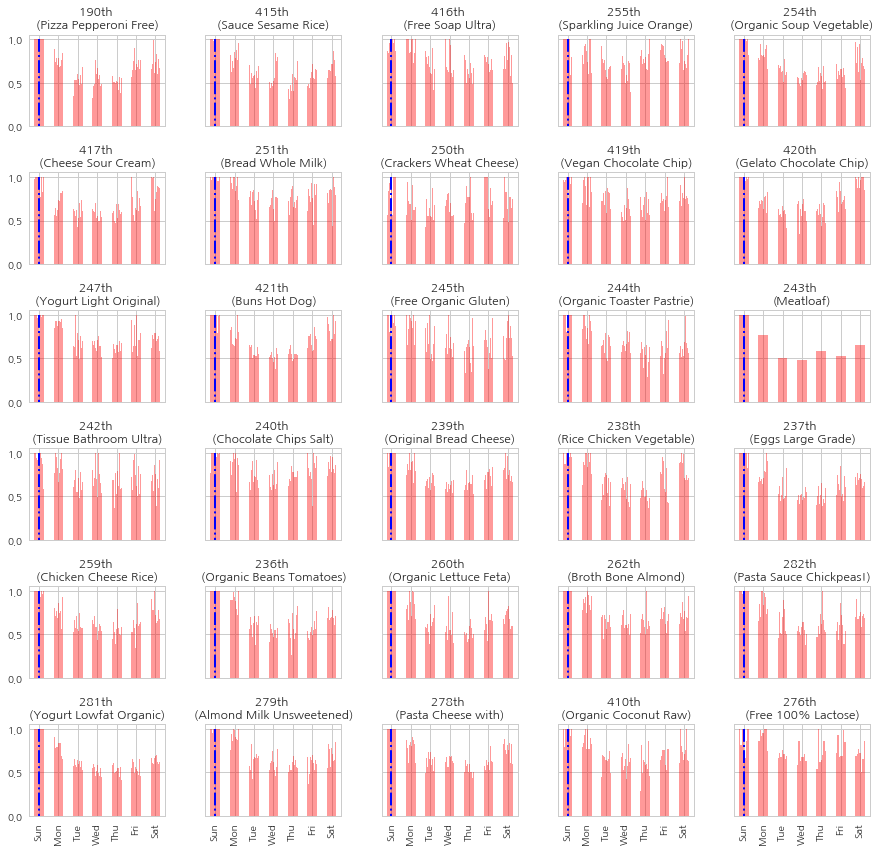

In [67]:
drawDOWCluster(5,6  , dow_cid_ds[dow_cid_ds.dow==0][:30].cid.values.tolist())

####  월요일 가장 많이 팔린 클러스터들의 요일별 이용 구패 패턴이다. 
*  cereal, nut, yogurt, coffee 등 오전에 팔리는  제품과 비슷한 성향이 있다. 

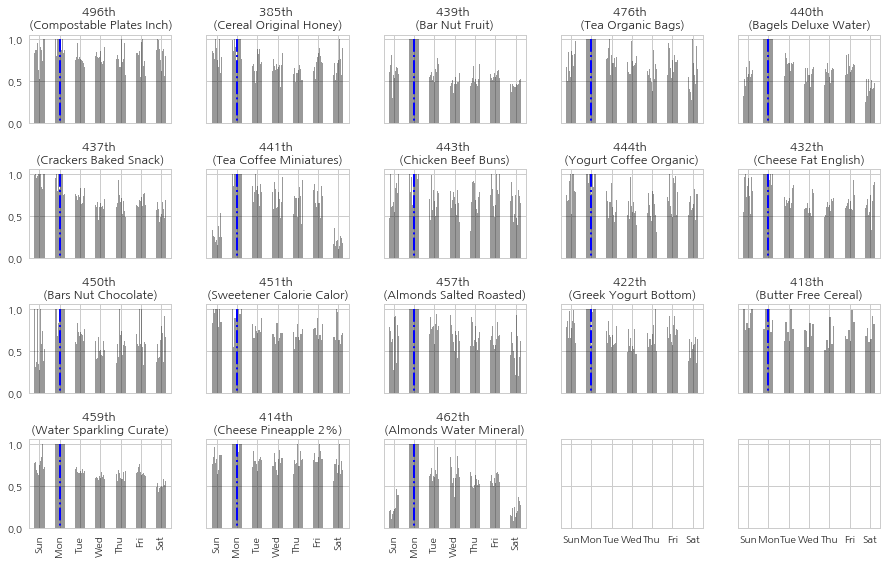

In [68]:
drawDOWCluster(5,4 , dow_cid_ds[dow_cid_ds.dow==1][:18].cid.values.tolist())

####  목요일에 가장 많이 팔린 클러스터들의 요일별 이용 구패 패턴이다. 
* 2개의 클러스터만 해당하지만, 특징이 명확하다. 
* Only 맛있는 맥주!!!  그외에는 없다. 

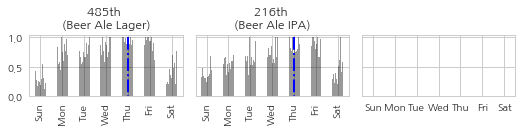

In [69]:
drawDOWCluster(3,1  , dow_cid_ds[dow_cid_ds.dow==4][:18].cid.values.tolist())

#### 금요일에 가장 많이 팔린 클러스터들의 요일별 이용 구패 패턴이다. 
* Wine, pinot, vodka, resema imported 등 술과 저녁 만찬에 관련된 패턴이 두드러 진다. 

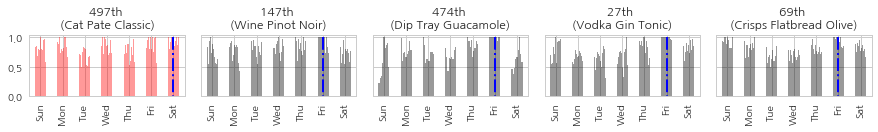

In [70]:
drawDOWCluster(5,1 , dow_cid_ds[dow_cid_ds.dow==5][:18].cid.values.tolist())